In [63]:
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import keras

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


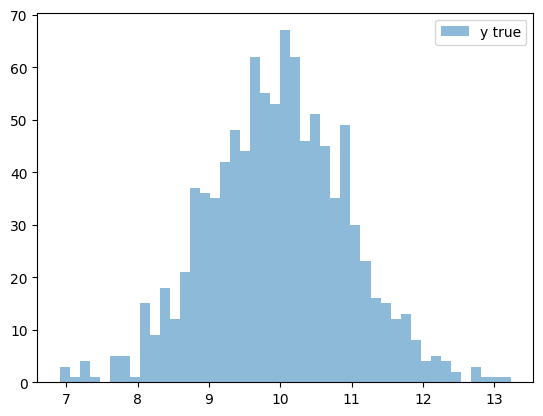

In [64]:
S=1
scale = 1
means = [10]
# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

T=1000
# create random state for sampling
seed=360
rng = np.random.RandomState(seed)
y_TS = np.array([dist.rvs(size=T, random_state=rng) for dist in data_distributions]).T
assert(y_TS.shape == (T, S))

# empty input
x_TF = np.zeros(shape=(1000,0))

plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=45, label='y true')
plt.legend()

In [65]:
inputs = keras.Input(shape=0)
linear_layer = keras.layers.Dense(S, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [66]:
predicted_means = linear_layer(inputs)
distributions = distribution_layer(predicted_means)
model = keras.Model(inputs=inputs, outputs=distributions)

In [67]:
x_TF = np.zeros(shape=(1000,0))
model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(0, 1), (1,)]


In [68]:
biases = model.trainable_variables[1]
biases.assign(means)

print(f'Biases {model.get_weights()[1]}')

Biases [10.]


In [71]:
M=2
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
assert(sample_y_MTS.shape == (M, T, S))

sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS)
sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)

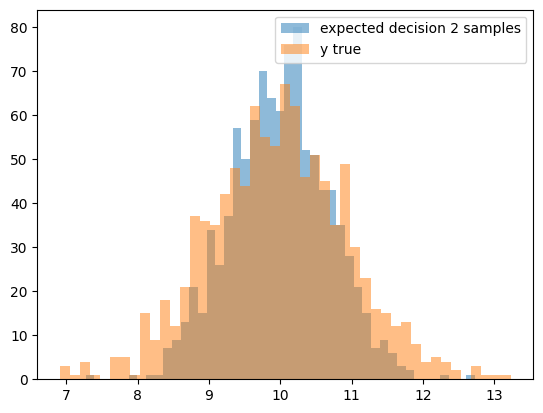

In [73]:
plt.hist(tf.reshape(expected_actions_TS, [-1]).numpy(),alpha=0.5, bins=45, label=f'expected decision {M} samples')
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=45, label='y true')
plt.legend()

In [15]:
# set to true value, should have 0 graident
variable = model.trainable_variables[1]
variable.assign([10.0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([10.], dtype=float32)>

In [80]:
M = 2

model_distributions = model(x_TF)
sample_y_2TS = model_distributions.sample(2)

grad_theta_wrt_phi_2TS = (sample_y_2TS - model.trainable_variables[1])*sample_y_2TS
grad_theta_wrt_phi2_TS = tf.reduce_mean(grad_theta_wrt_phi_2TS, axis=0)

sample_actions_2TS = tf.identity(sample_y_2TS)
expected_actions2_TS = tf.reduce_mean(sample_actions_2TS, axis=0)
loss2_T = keras.losses.mean_squared_error(y_TS, expected_actions2_TS)
loss2 = tf.reduce_mean(loss2_T)
grad_L_wrt_theta2_TS = -2.0/S*(y_TS-expected_actions2_TS)

analytical_gradient_2TS = grad_theta_wrt_phi_2TS*tf.expand_dims(grad_L_wrt_theta2_TS,axis=0)
analytical_gradient2_TS = grad_theta_wrt_phi2_TS*grad_L_wrt_theta2_TS

In [81]:
tf.reduce_mean(tf.reduce_mean(analytical_gradient_2TS, axis=0),axis=0)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([10.276009], dtype=float32)>

In [82]:
tf.reduce_mean(analytical_gradient2_TS, axis=0)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([10.276009], dtype=float32)>

In [170]:
M = 1000

model_distributions = model(x_TF)
sample_y_1kTS = model_distributions.sample(1000)

grad_theta_wrt_phi_1kTS = (sample_y_1kTS - model.trainable_variables[1])*sample_y_1kTS
grad_theta_wrt_phi1k_TS = tf.reduce_mean(grad_theta_wrt_phi_1kTS, axis=0)

sample_actions_1kTS = tf.identity(sample_y_1kTS)
expected_actions1k_TS = tf.reduce_mean(sample_actions_1kTS, axis=0)
loss1k_T = keras.losses.mean_squared_error(y_TS, expected_actions1k_TS)
loss1k = tf.reduce_mean(loss1k_T)
grad_L_wrt_theta1k_TS = -2.0/S*(y_TS-expected_actions1k_TS)

analytical_gradient_1kTS = grad_theta_wrt_phi_1kTS*tf.expand_dims(grad_L_wrt_theta1k_TS,axis=0)
analytical_gradient1k_TS = grad_theta_wrt_phi1k_TS*grad_L_wrt_theta1k_TS

In [171]:
tf.reduce_mean(tf.reduce_mean(analytical_gradient_1kTS[:2,:,:], axis=0),axis=0)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00567064], dtype=float32)>

In [145]:
tf.reduce_mean(tf.reduce_mean(analytical_gradient1k_TS, axis=0),axis=0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.106253795>

# WHY ARE THE FIRST 2 ROWS OF THE 1k MODEL DIFFERENT THAN THE ONE WITH 2 ROWS

## Step 1. The sample

In [177]:
# print min, mean, max, of first two rows of sample_y_1kTS
# in numpy
print(f'Min, mean, max of first two rows of sample_y_1kTS: {np.min(sample_y_1kTS[:2,:,:]), np.mean(sample_y_1kTS[:2,:,:]), np.max(sample_y_1kTS[:2,:,:])}')
print(f'Min, mean, and max of sample_y_2TS: {np.min(sample_y_2TS), np.mean(sample_y_2TS), np.max(sample_y_2TS)}')


Min, mean, max of first two rows of sample_y_1kTS: (6.3425617, 9.9964695, 13.9328985)
Min, mean, and max of sample_y_2TS: (6.8631816, 9.999309, 14.094243)


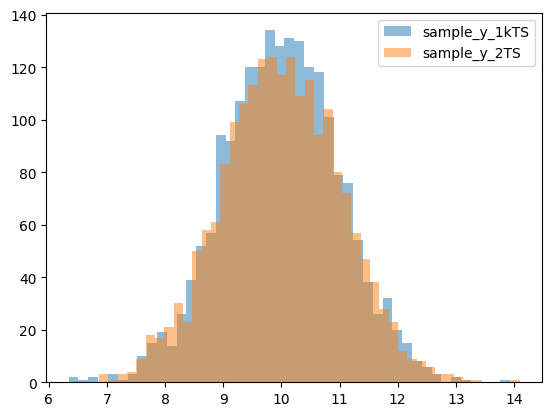

In [179]:
# graph histograms of first 2 rows and 2 row version
plt.hist(tf.reshape(sample_y_1kTS[:2,:,:], [-1]).numpy(),alpha=0.5, bins=45, label='sample_y_1kTS')
plt.hist(tf.reshape(sample_y_2TS, [-1]).numpy(),alpha=0.5, bins=45, label='sample_y_2TS')
plt.legend()

I am convinced sampling is not the issue

## Step 2 
The analytical gradient calculation
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$
$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi_\mu$$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) a(y)$$

In [180]:
# print min, mean, max, of first two rows of grad_theta_wrt_phi
# in numpy
print(f'Min, mean, max of first two rows of grad_theta_wrt_phi_1kTS: {np.min(grad_theta_wrt_phi_1kTS[:2,:,:]), np.mean(grad_theta_wrt_phi_1kTS[:2,:,:]), np.max(grad_theta_wrt_phi_1kTS[:2,:,:])}')
print(f'Min, mean, and max of grad_theta_wrt_phi_2TS: {np.min(grad_theta_wrt_phi_2TS), np.mean(grad_theta_wrt_phi_2TS), np.max(grad_theta_wrt_phi_2TS)}')

Min, mean, max of first two rows of grad_theta_wrt_phi_1kTS: (-23.197529, 0.9599906, 54.796677)
Min, mean, and max of grad_theta_wrt_phi_2TS: (-21.528555, 1.0410581, 57.705257)


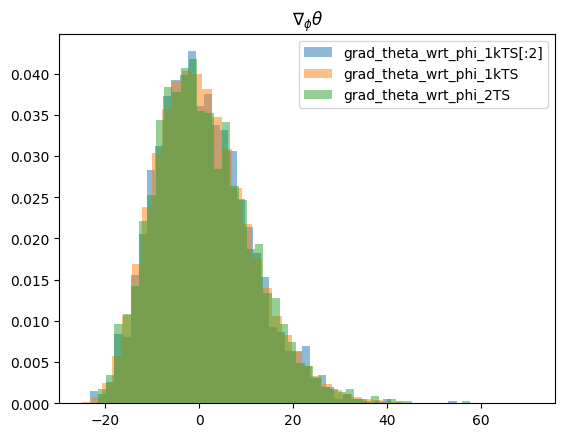

In [189]:
# graph histograms: with heights normalized
plt.hist(tf.reshape(grad_theta_wrt_phi_1kTS[:2,:,:], [-1]).numpy(),alpha=0.5, bins=45, label='grad_theta_wrt_phi_1kTS[:2]', density=True)
plt.hist(tf.reshape(grad_theta_wrt_phi_1kTS[:,:,:], [-1]).numpy(),alpha=0.5, bins=45, label='grad_theta_wrt_phi_1kTS', density=True)
plt.hist(tf.reshape(grad_theta_wrt_phi_2TS, [-1]).numpy(),alpha=0.5, bins=45, label='grad_theta_wrt_phi_2TS', density=True)
plt.title(r'$\nabla_\phi \theta$')
plt.legend()

Weirdly right-tailed, but not broken

## Step 3, the action
this really shouldnt be broken


In [190]:
# print min, mean, max, of first two rows of expected_actions
# in numpy
print(f'Min, mean, max of first two rows of expected_actions1k_TS: {np.min(expected_actions1k_TS[:2,:]), np.mean(expected_actions1k_TS[:2,:]), np.max(expected_actions1k_TS[:2,:])}')  
print(f'Min, mean, max of expected_actions2_TS: {np.min(expected_actions2_TS), np.mean(expected_actions2_TS), np.max(expected_actions2_TS)}')

Min, mean, max of first two rows of expected_actions1k_TS: (9.997336, 10.036554, 10.075772)
Min, mean, max of expected_actions2_TS: (7.557258, 9.99931, 12.225384)


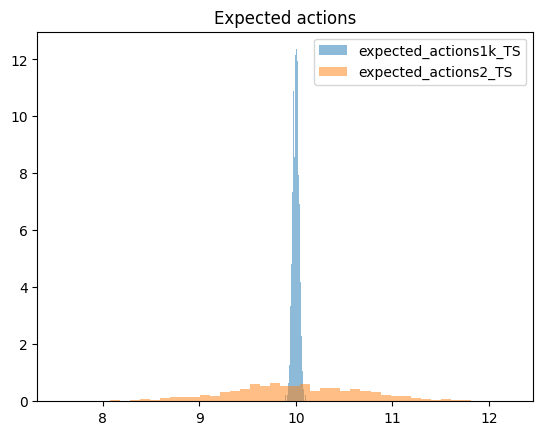

In [198]:
# graph histograms
#plt.hist(tf.reshape(expected_actions1k_TS[:2,:], [-1]).numpy(),alpha=0.5, bins=45, label='expected_actions1k_TS[:2]', density=True)
plt.hist(tf.reshape(expected_actions1k_TS, [-1]).numpy(),alpha=0.5, bins=45, label='expected_actions1k_TS', density=True)
plt.hist(tf.reshape(expected_actions2_TS, [-1]).numpy(),alpha=0.5, bins=45, label='expected_actions2_TS', density=True)
plt.title('Expected actions')
plt.legend()


Much less variance in the expected actions when using 1k samples, maybe action variance + right-tailed = bias?

## Step 4, the loss
should also not be broken

In [200]:
# plot min,mean max of loss
print(f'Min, mean, max of loss1k_T: {np.min(loss1k_T), np.mean(loss1k_T), np.max(loss1k_T)}')
print(f'Min, mean, max of loss2_T: {np.min(loss2_T), np.mean(loss2_T), np.max(loss2_T)}')


Min, mean, max of loss1k_T: (7.181461e-08, 0.9626479, 10.602831)
Min, mean, max of loss2_T: (3.1018863e-07, 1.4605542, 17.536263)


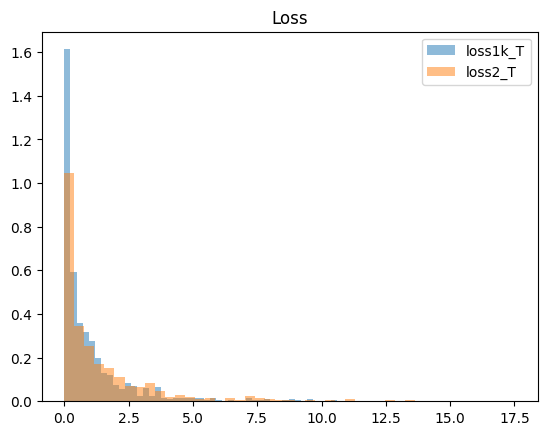

In [201]:
# histograms
plt.hist(tf.reshape(loss1k_T, [-1]).numpy(),alpha=0.5, bins=45, label='loss1k_T', density=True)
plt.hist(tf.reshape(loss2_T, [-1]).numpy(),alpha=0.5, bins=45, label='loss2_T', density=True)
plt.title('Loss')
plt.legend()

Nothing unexpected

## Step 5, loss gradient

In [207]:
# print stats for grad_L
print(f'Min, mean, max of grad_L_wrt_theta1k_TS: {np.min(grad_L_wrt_theta1k_TS), np.mean(grad_L_wrt_theta1k_TS), np.max(grad_L_wrt_theta1k_TS)}')
print(f'Min, mean, max of grad_L_wrt_theta2_TS: {np.min(grad_L_wrt_theta2_TS), np.mean(grad_L_wrt_theta2_TS), np.max(grad_L_wrt_theta2_TS)}')


Min, mean, max of grad_L_wrt_theta1k_TS: (-6.512398, 0.06965944, 6.19613)
Min, mean, max of grad_L_wrt_theta2_TS: (-7.34704, 0.06370531, 8.375264)


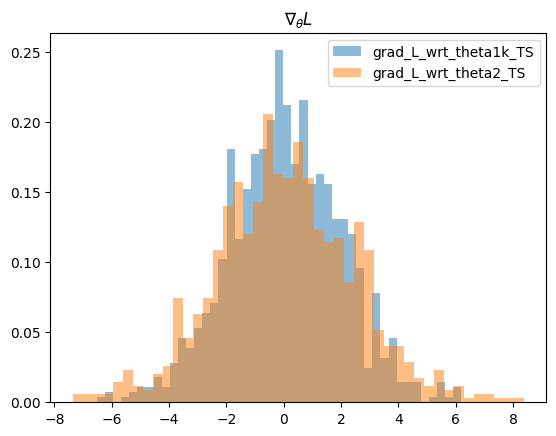

In [206]:
# histograms
plt.hist(tf.reshape(grad_L_wrt_theta1k_TS, [-1]).numpy(),alpha=0.5, bins=45, label='grad_L_wrt_theta1k_TS', density=True)
plt.hist(tf.reshape(grad_L_wrt_theta2_TS, [-1]).numpy(),alpha=0.5, bins=45, label='grad_L_wrt_theta2_TS', density=True)
plt.title(r'$\nabla_\theta L$')
plt.legend()

Looks normal

## Step 6: The analytical gradient
$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$


In [209]:
# stats of analytical
print(f'Min, mean, max of analytical_gradient_1kTS: {np.min(analytical_gradient_1kTS), np.mean(analytical_gradient_1kTS), np.max(analytical_gradient_1kTS)}')
print(f'Min, mean, max, of first 2 rows of analytical_gradient_1kTS: {np.min(analytical_gradient_1kTS[:2,:,:]), np.mean(analytical_gradient_1kTS[:2,:,:]), np.max(analytical_gradient_1kTS[:2,:,:])}')
print(f'Min, mean, max of analytical_gradient_2TS: {np.min(analytical_gradient_2TS), np.mean(analytical_gradient_2TS), np.max(analytical_gradient_2TS)}')

Min, mean, max of analytical_gradient_1kTS: (-278.75085, 0.115778305, 318.62714)
Min, mean, max, of first 2 rows of analytical_gradient_1kTS: (-126.94157, -0.005670593, 177.94695)
Min, mean, max of analytical_gradient_2TS: (-64.58103, 10.27601, 483.29678)


Means very different

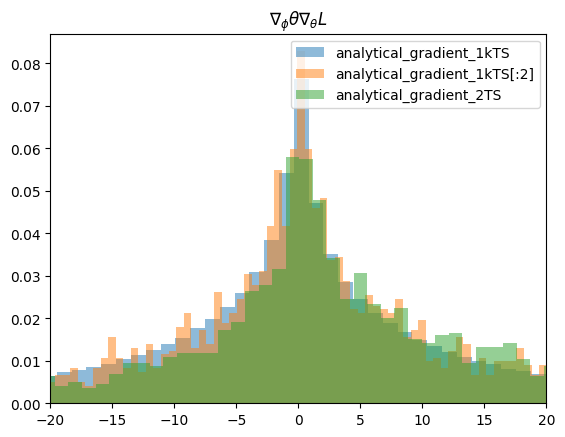

In [213]:
# Histograms
plt.hist(tf.reshape(analytical_gradient_1kTS, [-1]).numpy(),alpha=0.5, bins=500, label='analytical_gradient_1kTS', density=True)
plt.hist(tf.reshape(analytical_gradient_1kTS[:2,:,:], [-1]).numpy(),alpha=0.5, bins=500, label='analytical_gradient_1kTS[:2]', density=True)
plt.hist(tf.reshape(analytical_gradient_2TS, [-1]).numpy(),alpha=0.5, bins=500, label='analytical_gradient_2TS', density=True)
# set x limit to -20, 20
plt.xlim(-20,20)
plt.title(r'$\nabla_\phi \theta \nabla_\theta L$')
plt.legend()